# Step 3-3 Multivariate DL models for G20 countries

### Necessary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Conv1D, Flatten
from keras.layers import RepeatVector, TimeDistributed, Dropout
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import warnings
import os

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

### Config

In [2]:
TARGET_VARIABLES = 'co2'
TARGET_PCT_CHANGE = 'co2_pct_change'
SELECTED_COUNTRIES = ['United States', 'China', 'India']
G7_COUNTRIES = ['United States', 'China', 'India', 'Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom']
G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

MAX_LAGS = 4
N_STEPS_IN = 5
N_STEPS_OUT = 1
TEST_SIZE = 9
VALIDATION_SPLIT = 0.1

save_dir = 'data/03_03_results'
os.makedirs(save_dir, exist_ok=True)

DL_MODELS_ORDER = ['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']

MULTIVARIATE_FEATURES = [
    'gdp',
    'primary_energy_consumption',
    'population',
    'biofuel_share_energy',
    'low_carbon_share_energy',
    'methane',
    'nitrous_oxide'
]

ALL_FEATURES = [TARGET_VARIABLES] + MULTIVARIATE_FEATURES

### Hyperparameter Tuning Config

In [3]:
DL_HYPERPARAMS = {
    'LSTM': {
        'hidden': [16, 32],
        'dropout': [0.0, 0.1, 0.2],
        'lr': [0.0001, 0.001],
        'l2': [0.001, 0.01],
        'batch_size': [16, 32],
        'epochs': [100]
    },
    'Bi-LSTM': {
        'hidden': [16, 32],
        'dropout': [0.0, 0.1, 0.2],
        'lr': [0.0001, 0.001],
        'l2': [0.001, 0.01],
        'l2_recurrent': [0.001],
        'batch_size': [16, 32],
        'epochs': [100]
    },
    'ED-LSTM': {
        'hidden': [8, 16],
        'dropout': [0.0, 0.1, 0.2],
        'lr': [0.0001, 0.001],
        'l2': [0.001, 0.01],
        'batch_size': [16, 32],
        'epochs': [100]
    },
    'CNN': {
        'filters': [16, 32],
        'lr': [0.0001, 0.001],
        'l2': [0.001, 0.01],
        'batch_size': [16, 32],
        'epochs': [100]
    }
}

In [4]:
def generate_config_comb(params):
    keys = params.keys()
    values = params.values()

    configs = []
    for comb in product(*values):
        config = dict(zip(keys, comb))
        configs.append(config)

    return configs

In [5]:
DL_CONFIGS = {}
for model_name, params in DL_HYPERPARAMS.items():
    DL_CONFIGS[model_name] = generate_config_comb(params)

### Data Load

In [6]:
def load_data(save_dir='data'):
    data_files = {
        'g20_interpolated_df': os.path.join(save_dir, 'g20_interpolated_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [7]:
data = load_data()
g20_interpolated_df = data['g20_interpolated_df']
g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]

Loaded g20_interpolated_df: (855, 992)
Loaded g20_lag_df: (3744, 992)


### Data Prep

In [8]:
def tts_by_year(interpolated_df, full_df, countries, test_size=TEST_SIZE):
    train_data = {}
    test_data = {}

    for country in countries:
        country_train = interpolated_df[interpolated_df['country'] == country].sort_values('year').copy()

        country_full = full_df[full_df['country'] == country].sort_values('year').copy()
        split_idx = len(country_full) - test_size
        country_test = country_full.iloc[split_idx:].copy()

        train_data[country] = country_train
        test_data[country] = country_test

        print(f"\n{country}:")
        print(f"    Train: {len(country_train)} samples, years {country_train['year'].min()}-{country_train['year'].max()}")
        print(f"    Test:  {len(country_test)} samples, years {country_test['year'].min()}-{country_test['year'].max()}")

    train_df = pd.concat(train_data.values(), ignore_index=True)
    test_df = pd.concat(test_data.values(), ignore_index=True)

    return train_df, test_df

In [9]:
g20_train_df, g20_test_df = tts_by_year(g20_interpolated_df, g20_lag_1969_df, G20_COUNTRIES)


United States:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

China:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

Japan:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

Germany:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

United Kingdom:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

France:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

Italy:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

Canada:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

Brazil:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

Russia:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

India:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

Australia:
    Train: 45 samples, years 1

### Helper functions

In [10]:
def mase(y_actual, y_pred, period=1):
    mae_forecast = mean_absolute_error(y_actual, y_pred)

    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]

    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)

    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

In [11]:
def calculate_pct_change(df, features, max_lags=MAX_LAGS):
    df_copy = df.copy()
    df_copy = df_copy.sort_values(['country', 'year']).reset_index(drop=True)
    pct_change_cols = []

    for feature in features:
        if feature not in df_copy.columns:
            continue

        # Pct change on current values
        lag1_col = f"{feature}_lag1"
        if lag1_col in df_copy.columns:
            df_copy[f"{feature}_pct_change"] = ((df_copy[feature] - df_copy[lag1_col]) / df_copy[lag1_col] * 100)
            pct_change_cols.append(f"{feature}_pct_change")

        # Pct change on lagged values
        for lag in range(1, max_lags):
            lag_col = f"{feature}_lag{lag}"
            prev_lag_col = f"{feature}_lag{lag+1}"
            
            if lag_col in df_copy.columns and prev_lag_col in df_copy.columns:
                df_copy[f"{lag_col}_pct_change"] = ((df_copy[lag_col] - df_copy[prev_lag_col]) / df_copy[prev_lag_col] * 100)
                pct_change_cols.append(f"{lag_col}_pct_change")

        # Lag4 for the first row = 0, then shift lag3_pct by country
        last_lag_col = f"{feature}_lag{max_lags}"
        lag3_pct_col = f"{feature}_lag{max_lags-1}_pct_change"

        if last_lag_col in df_copy.columns and lag3_pct_col in df_copy.columns:
            df_copy[f"{last_lag_col}_pct_change"] = df_copy.groupby('country')[lag3_pct_col].shift(1).fillna(0)
            pct_change_cols.append(f"{last_lag_col}_pct_change")
            
        df_copy = df_copy.replace([np.inf, -np.inf], np.nan)
    
    return df_copy, pct_change_cols

In [12]:
def create_sequences(data, n_steps_in):
    X, y = [], []

    for i in range(len(data) - n_steps_in):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in, 0]) # Target co2 is the first column

    return np.array(X), np.array(y)

### Model Builds

In [13]:
def build_lstm(input_shape, hidden=16, dropout=0.0, lr=0.001, l2=0.01, epochs=100):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l2)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [14]:
def build_bilstm(input_shape, hidden=8, dropout=0.0, lr=0.001, l2=0.001, l2_recurrent=0.01, epochs=100):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=regularizers.l2(l2), recurrent_regularizer=regularizers.l2(l2_recurrent)),
                        input_shape=input_shape),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [15]:
def build_edlstm(input_shape, hidden=16, dropout=0.0, lr=0.001, l2=0.01, epochs=100):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l2)),
        Dropout(dropout),
        RepeatVector(N_STEPS_OUT),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(l2)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [16]:
def build_cnn(input_shape, filters=16, lr=0.001, l2=0.01, epochs=100):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=regularizers.l2(l2)),
        Flatten(),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

### Model Train

In [17]:
# Data Prep
def prepare_train_data(train_df, features, target):
    all_train_pct_data = []
    country_train_info = {}

    for country in train_df['country'].unique():
        country_data = train_df[train_df['country'] == country].sort_values('year').reset_index(drop=True)

        # Caculate pct_change for all features
        country_pct, pct_cols = calculate_pct_change(country_data, features, MAX_LAGS)

        # pct_change values for all features
        feature_pct_values = []
        for feat in features:
            pct_col = f"{feat}_pct_change"
            if pct_col in country_pct.columns:
                pct_values = country_pct[pct_col].fillna(0).values
                feature_pct_values.append(pct_values)
            else:
                print(f"{pct_col} not in {country}")
        
        # Stacking features: shape (timesteps, n_features)
        feature_pct_array = np.column_stack(feature_pct_values)
        all_train_pct_data.append(feature_pct_array)
        
        country_train_info[country] = {
            'pct_values': feature_pct_array,
            'original_values': country_data[target].values,
            'years': country_data['year'].values
        }
        
        print(f"{country} pct_values shape: {feature_pct_array.shape}")
    
    return all_train_pct_data, country_train_info

In [18]:
g20_train_pct_data, g20_country_train_info = prepare_train_data(g20_train_df, ALL_FEATURES, TARGET_VARIABLES)

United States pct_values shape: (45, 8)
China pct_values shape: (45, 8)
Japan pct_values shape: (45, 8)
Germany pct_values shape: (45, 8)
United Kingdom pct_values shape: (45, 8)
France pct_values shape: (45, 8)
Italy pct_values shape: (45, 8)
Canada pct_values shape: (45, 8)
Brazil pct_values shape: (45, 8)
Russia pct_values shape: (45, 8)
India pct_values shape: (45, 8)
Australia pct_values shape: (45, 8)
Mexico pct_values shape: (45, 8)
Indonesia pct_values shape: (45, 8)
Turkey pct_values shape: (45, 8)
Saudi Arabia pct_values shape: (45, 8)
South Africa pct_values shape: (45, 8)
Argentina pct_values shape: (45, 8)
South Korea pct_values shape: (45, 8)


In [19]:
# Fit universal StandardScaler
def fit_scaler(all_train_pct_data, features):
    all_train_pct_combined = np.vstack(all_train_pct_data)
    print(f"Combined train data shape: {all_train_pct_combined.shape}")

    scaler = StandardScaler()
    scaler.fit(all_train_pct_combined)

    for i, feat in enumerate(features):
        print(f"{feat} mean={scaler.mean_[i]:.4f}, std={np.sqrt(scaler.var_[i]):.4f}")

    return scaler

In [20]:
scaler = fit_scaler(g20_train_pct_data, ALL_FEATURES)

Combined train data shape: (855, 8)
co2 mean=3.1697, std=6.0995
gdp mean=4.1104, std=3.9942
primary_energy_consumption mean=3.3644, std=4.9041
population mean=1.3660, std=1.1642
biofuel_share_energy mean=13.6640, std=82.8953
low_carbon_share_energy mean=4.3946, std=34.6631
methane mean=0.8311, std=4.7362
nitrous_oxide mean=1.2960, std=7.3238


In [21]:
def create_train_sequences(country_train_info, scaler):
    X_train_all = []
    y_train_all = []

    for country, info in country_train_info.items():
        pct_values = info['pct_values']
        scaled_values = scaler.transform(pct_values)

        X_country, y_country = create_sequences(scaled_values, N_STEPS_IN)

        X_train_all.append(X_country)
        y_train_all.append(y_country)

        print(f"{country} X_train shape: {X_country.shape}, y_train shape: {y_country.shape}")
    
    X_train = np.vstack(X_train_all)
    y_train = np.concatenate(y_train_all)
    
    print(f"\nCombined training sequences:")
    print(f"    X_train shape: {X_train.shape}")
    print(f"    y_train shape: {y_train.shape}")
    
    return X_train, y_train

In [22]:
X_train, y_train = create_train_sequences(g20_country_train_info, scaler)

United States X_train shape: (40, 5, 8), y_train shape: (40,)
China X_train shape: (40, 5, 8), y_train shape: (40,)
Japan X_train shape: (40, 5, 8), y_train shape: (40,)
Germany X_train shape: (40, 5, 8), y_train shape: (40,)
United Kingdom X_train shape: (40, 5, 8), y_train shape: (40,)
France X_train shape: (40, 5, 8), y_train shape: (40,)
Italy X_train shape: (40, 5, 8), y_train shape: (40,)
Canada X_train shape: (40, 5, 8), y_train shape: (40,)
Brazil X_train shape: (40, 5, 8), y_train shape: (40,)
Russia X_train shape: (40, 5, 8), y_train shape: (40,)
India X_train shape: (40, 5, 8), y_train shape: (40,)
Australia X_train shape: (40, 5, 8), y_train shape: (40,)
Mexico X_train shape: (40, 5, 8), y_train shape: (40,)
Indonesia X_train shape: (40, 5, 8), y_train shape: (40,)
Turkey X_train shape: (40, 5, 8), y_train shape: (40,)
Saudi Arabia X_train shape: (40, 5, 8), y_train shape: (40,)
South Africa X_train shape: (40, 5, 8), y_train shape: (40,)
Argentina X_train shape: (40, 5, 8)

### Hyperparameter Tuning

In [23]:
def tune_hyperparams(X_train, y_train, validation_split=VALIDATION_SPLIT):
    dl_models = {
        'LSTM': build_lstm,
        'Bi-LSTM': build_bilstm,
        'ED-LSTM': build_edlstm,
        'CNN': build_cnn
    }

    best_configs = {}

    for model_name, model_func in dl_models.items():
        print(f"\nTuning {model_name}")

        best_val_loss = np.inf
        best_config = None

        # Reshape y_train for ED-LSTM output shape (n_samples, n_steps_out, n_features)
        if model_name == 'ED-LSTM':
            y_train_model = y_train.reshape(-1, N_STEPS_OUT, 1)
            print(f"ED-LSTM target shape: {y_train_model.shape}")
        else:
            y_train_model = y_train
            print(f"{model_name} target shape: {y_train_model.shape}")

        for config in DL_CONFIGS[model_name]:
            input_shape = (X_train.shape[1], X_train.shape[2])

            model = model_func(input_shape, **config)

            callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]

            epochs = config['epochs']
            history = model.fit(
                X_train, y_train_model, 
                epochs=epochs, 
                batch_size=16,
                callbacks=callbacks,
                validation_split=validation_split,
                verbose=0
            )

            val_loss = history.history['val_loss'][-1]

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config = config

            tf.keras.backend.clear_session()
            del model

        best_configs[model_name] = best_config
        print(f"\nBest {model_name} config: {best_config}")

    return best_configs

In [24]:
"""best_configs = tune_hyperparams(X_train, y_train)

for model_name, config in best_configs.items():
    print(f"\n{model_name}:")
    for param, value in config.items():
        print(f"    {param}: {value}")"""

'best_configs = tune_hyperparams(X_train, y_train)\n\nfor model_name, config in best_configs.items():\n    print(f"\n{model_name}:")\n    for param, value in config.items():\n        print(f"    {param}: {value}")'

In [25]:
# Since for loop for all the models take long, this has been changed to breakdown
best_configs = {}

# Tuning for LSTM
model_name = 'LSTM'
best_val_loss = np.inf
best_config = None

y_train_model = y_train
print(f"LSTM target shape: {y_train_model.shape}")

for config in DL_CONFIGS[model_name]:
    input_shape = (X_train.shape[1], X_train.shape[2])

    batch_size = config['batch_size']

    model_config = {k: v for k, v in config.items() if k not in ['batch_size', 'epochs']}
    model = build_lstm(input_shape, **model_config)
    
    callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    
    epochs = config['epochs']
    history = model.fit(
        X_train, y_train_model, 
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=callbacks,
        validation_split=VALIDATION_SPLIT,
        verbose=0
    )
    
    val_loss = history.history['val_loss'][-1]
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = config
    
    tf.keras.backend.clear_session()
    del model

best_configs['LSTM'] = best_config
print(f"\nBest LSTM config: {best_config}")
print(f"    Best val_loss: {best_val_loss:.6f}")

LSTM target shape: (760,)

Best LSTM config: {'hidden': 16, 'dropout': 0.1, 'lr': 0.001, 'l2': 0.001, 'batch_size': 32, 'epochs': 100}
    Best val_loss: 0.717102


In [26]:
# Tuning for Bi-LSTM
model_name = 'Bi-LSTM'
best_val_loss = np.inf
best_config = None

y_train_model = y_train
print(f"Bi-LSTM target shape: {y_train_model.shape}")

for config in DL_CONFIGS[model_name]:
    input_shape = (X_train.shape[1], X_train.shape[2])

    batch_size = config['batch_size']

    model_config = {k: v for k, v in config.items() if k not in ['batch_size', 'epochs']}
    model = build_bilstm(input_shape, **model_config)
    
    callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    
    epochs = config['epochs']
    history = model.fit(
        X_train, y_train_model, 
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=callbacks,
        validation_split=VALIDATION_SPLIT,
        verbose=0
    )
    
    val_loss = history.history['val_loss'][-1]
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = config
    
    tf.keras.backend.clear_session()
    del model

best_configs['Bi-LSTM'] = best_config
print(f"\nBest Bi-LSTM config: {best_config}")
print(f"    Best val_loss: {best_val_loss:.6f}")

Bi-LSTM target shape: (760,)

Best Bi-LSTM config: {'hidden': 32, 'dropout': 0.0, 'lr': 0.0001, 'l2': 0.001, 'l2_recurrent': 0.001, 'batch_size': 16, 'epochs': 100}
    Best val_loss: 0.731651


In [27]:
# Tuning for ED-LSTM
model_name = 'ED-LSTM'
best_val_loss = np.inf
best_config = None

y_train_model = y_train.reshape(-1, N_STEPS_OUT, 1)
print(f"ED-LSTM target shape: {y_train_model.shape}")

for config in DL_CONFIGS[model_name]:
    input_shape = (X_train.shape[1], X_train.shape[2])

    batch_size = config['batch_size']

    model_config = {k: v for k, v in config.items() if k not in ['batch_size', 'epochs']}
    model = build_edlstm(input_shape, **model_config)
    
    callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    
    epochs = config['epochs']
    history = model.fit(
        X_train, y_train_model, 
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=callbacks,
        validation_split=VALIDATION_SPLIT,
        verbose=0
    )
    
    val_loss = history.history['val_loss'][-1]
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = config
    
    tf.keras.backend.clear_session()
    del model

best_configs['ED-LSTM'] = best_config
print(f"\nBest ED-LSTM config: {best_config}")
print(f"    Best val_loss: {best_val_loss:.6f}")

ED-LSTM target shape: (760, 1, 1)

Best ED-LSTM config: {'hidden': 8, 'dropout': 0.2, 'lr': 0.001, 'l2': 0.001, 'batch_size': 16, 'epochs': 100}
    Best val_loss: 0.722460


In [28]:
# Tuning CNN
model_name = 'CNN'
best_val_loss = np.inf
best_config = None

y_train_model = y_train
print(f"CNN target shape: {y_train_model.shape}")

for config in DL_CONFIGS[model_name]:
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    batch_size = config['batch_size']

    model_config = {k: v for k, v in config.items() if k not in ['batch_size', 'epochs']}
    model = build_cnn(input_shape, **model_config)
    
    callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    
    epochs = config['epochs']
    history = model.fit(
        X_train, y_train_model, 
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=callbacks,
        validation_split=VALIDATION_SPLIT,
        verbose=0
    )
    
    val_loss = history.history['val_loss'][-1]
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = config
    
    tf.keras.backend.clear_session()
    del model

best_configs['CNN'] = best_config
print(f"\nBest CNN config: {best_config}")
print(f"    Best val_loss: {best_val_loss:.6f}")

CNN target shape: (760,)

Best CNN config: {'filters': 16, 'lr': 0.0001, 'l2': 0.001, 'batch_size': 32, 'epochs': 100}
    Best val_loss: 0.758674


In [29]:
for model_name, config in best_configs.items():
    print(f"\n{model_name}:")
    for param, value in config.items():
        print(f"    {param}: {value}")


LSTM:
    hidden: 16
    dropout: 0.1
    lr: 0.001
    l2: 0.001
    batch_size: 32
    epochs: 100

Bi-LSTM:
    hidden: 32
    dropout: 0.0
    lr: 0.0001
    l2: 0.001
    l2_recurrent: 0.001
    batch_size: 16
    epochs: 100

ED-LSTM:
    hidden: 8
    dropout: 0.2
    lr: 0.001
    l2: 0.001
    batch_size: 16
    epochs: 100

CNN:
    filters: 16
    lr: 0.0001
    l2: 0.001
    batch_size: 32
    epochs: 100


### Train models with full training data

In [30]:
def train_dl_models(X_train, y_train, best_configs):
    dl_models = {
        'LSTM': build_lstm,
        'Bi-LSTM': build_bilstm,
        'ED-LSTM': build_edlstm,
        'CNN': build_cnn
    }

    trained_models = {}

    for model_name, model_func in dl_models.items():
        print(f"\nTraining {model_name}")

        config = best_configs[model_name]
        epochs = config['epochs']
        batch_size = config['batch_size']

        # Reshape y_train for ED-LSTM output shape (n_samples, n_steps_out, n_features)
        if model_name == 'ED-LSTM':
            y_train_model = y_train.reshape(-1, N_STEPS_OUT, 1)
        else:
            y_train_model = y_train

        input_shape = (X_train.shape[1], X_train.shape[2])

        model_config = {k: v for k, v in config.items() if k not in ['batch_size', 'epochs']}
        model = model_func(input_shape, **model_config)

        callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]

        history = model.fit(
            X_train, y_train_model,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        loss = history.history['loss'][-1]
        print(f"    Training loss: {loss:.4f}")

        trained_models[model_name] = {
            'model': model,
            'config': config
        }

    return trained_models

In [31]:
g20_trained_models = train_dl_models(X_train, y_train, best_configs)


Training LSTM
    Training loss: 0.5074

Training Bi-LSTM
    Training loss: 0.6086

Training ED-LSTM
    Training loss: 0.6393

Training CNN
    Training loss: 0.6883


### Evaluation

In [32]:
def eval_on_test(train_df, test_df, target, features, scaler, trained_models, selected_countries):
    all_results = {}

    for country in selected_countries:
        print(f"\n{country.upper()}")

        train_country = train_df[train_df['country'] == country].sort_values('year').reset_index(drop=True)
        test_country = test_df[test_df['country'] == country].sort_values('year').reset_index(drop=True)

        combined_data = pd.concat([train_country, test_country], ignore_index=True)

        # Calculating pct_change for combined data
        combined_pct, _ = calculate_pct_change(combined_data, features, MAX_LAGS)

        # Stack pct_change values for all features and target
        pct_change_values = []
        for feat in features:
            pct_col = f"{feat}_pct_change"
            if pct_col in combined_pct.columns:
                pct_values = combined_pct[pct_col].fillna(0).values
                pct_change_values.append(pct_values)

        stacked_combined_pct = np.column_stack(pct_change_values)
        
        # Fit the StandardScaler used before
        combined_scaled = scaler.transform(stacked_combined_pct)

        # Original values for calculating errors
        original_values = combined_data[target].values

        X_all, y_all = create_sequences(combined_scaled, N_STEPS_IN)

        X_test = X_all[-TEST_SIZE:]
        test_years = test_country['year'].values

        print(f"Test sequence shape: {X_test.shape}")

        country_results = {}

        for model_name, model_info in trained_models.items():
            model = model_info['model']
            config = model_info['config']

            # The model predicts scaled values due to the scaled train data
            preds_scaled = model.predict(X_test, verbose=0)

            # Flatten for ED-LSTM 3D output (n_samples, n_steps_out, features)
            if len(preds_scaled.shape) == 3:
                preds_scaled = preds_scaled[:, 0, 0]
            else:
                # Others flatten with ravel
                preds_scaled = preds_scaled.ravel()

            # Inverse transform co2 (first feature)
            tmp_array = np.zeros((len(preds_scaled), len(features)))
            tmp_array[:, 0] = preds_scaled
            preds_pct_inverse = scaler.inverse_transform(tmp_array)
            preds_pct_change = preds_pct_inverse[:, 0]

            # Denormalise pct change to forecasted actual CO2 values
            forecast = []
            test_start_idx = len(original_values) - TEST_SIZE

            for i in range(TEST_SIZE):
                prev_value = original_values[test_start_idx + i - 1]
                predicted_value = prev_value * (1 + preds_pct_change[i] / 100)
                forecast.append(predicted_value)

            forecast = np.array(forecast)
            actual_test = original_values[-TEST_SIZE:]
            
            # Calculate metrics
            individual_errors = np.abs(actual_test - forecast)
            rmse_score = np.sqrt(mean_squared_error(actual_test, forecast))
            mase_score = mase(actual_test, forecast)

            country_results[model_name] = {
                'forecast': forecast,
                'actual': actual_test,
                'individual_errors': individual_errors,
                'test_years': test_years,
                'RMSE': rmse_score,
                'MASE': mase_score,
                'best_config': config
            }

            print(f"\n  {model_name}")
            print(f"    RMSE: {rmse_score:.4f}")
            print(f"    MASE: {mase_score:.4f}")
            print(f"    Config: {config}")
        
        all_results[country] = country_results
    
    return all_results

In [33]:
dl_results = eval_on_test(g20_train_df, g20_test_df, TARGET_VARIABLES, ALL_FEATURES,
                          scaler, g20_trained_models, SELECTED_COUNTRIES)


UNITED STATES
Test sequence shape: (9, 5, 8)

  LSTM
    RMSE: 210.9536
    MASE: 0.8093
    Config: {'hidden': 16, 'dropout': 0.1, 'lr': 0.001, 'l2': 0.001, 'batch_size': 32, 'epochs': 100}

  Bi-LSTM
    RMSE: 242.9501
    MASE: 0.9550
    Config: {'hidden': 32, 'dropout': 0.0, 'lr': 0.0001, 'l2': 0.001, 'l2_recurrent': 0.001, 'batch_size': 16, 'epochs': 100}

  ED-LSTM
    RMSE: 239.0302
    MASE: 0.9407
    Config: {'hidden': 8, 'dropout': 0.2, 'lr': 0.001, 'l2': 0.001, 'batch_size': 16, 'epochs': 100}

  CNN
    RMSE: 267.3782
    MASE: 1.1716
    Config: {'filters': 16, 'lr': 0.0001, 'l2': 0.001, 'batch_size': 32, 'epochs': 100}

CHINA
Test sequence shape: (9, 5, 8)

  LSTM
    RMSE: 267.5716
    MASE: 0.9076
    Config: {'hidden': 16, 'dropout': 0.1, 'lr': 0.001, 'l2': 0.001, 'batch_size': 32, 'epochs': 100}

  Bi-LSTM
    RMSE: 294.9877
    MASE: 0.9615
    Config: {'hidden': 32, 'dropout': 0.0, 'lr': 0.0001, 'l2': 0.001, 'l2_recurrent': 0.001, 'batch_size': 16, 'epochs': 100}

### Summary Table

In [34]:
summary_data = []

for country in SELECTED_COUNTRIES:
    for model_name, result in dl_results[country].items():
        summary_data.append({
            'Country': country,
            'Model': model_name,
            'RMSE': result['RMSE'],
            'MASE': result['MASE']
        })

summary_df = pd.DataFrame(summary_data)

# RMSE pivot table
rmse_pivot = summary_df.pivot(index='Model', columns='Country', values='RMSE')
rmse_pivot = rmse_pivot.round(4)

# Ordering models
rmse_pivot = rmse_pivot.reindex([m for m in DL_MODELS_ORDER if m in rmse_pivot.index])

print(rmse_pivot)

Country     China     India  United States
Model                                     
LSTM     267.5716  115.5981       210.9536
Bi-LSTM  294.9877  124.7302       242.9501
ED-LSTM  312.6255  123.9698       239.0302
CNN      310.9564  138.0351       267.3782


In [35]:
# MASE pivot table
mase_pivot = summary_df.pivot(index='Model', columns='Country', values='MASE')
mase_pivot = mase_pivot.round(4)

# Ordering models
mase_pivot = mase_pivot.reindex([m for m in DL_MODELS_ORDER if m in mase_pivot.index])

print(mase_pivot)

Country   China   India  United States
Model                                 
LSTM     0.9076  0.6263         0.8093
Bi-LSTM  0.9615  0.6859         0.9550
ED-LSTM  1.0255  0.6793         0.9407
CNN      0.9936  0.7245         1.1716


In [36]:
pivot_table_filepath = os.path.join(save_dir, 'G20_multivariate_DL_summary.md')
with open(pivot_table_filepath, 'w') as f:
    f.write("# Summary of Multivariate G20 DL models\n\n")
    f.write("RMSE of each DL model trained on G20 countries combined dataset with selected features\n\n")
    f.write("The target countries are the US, China, and India\n\n")
    f.write(rmse_pivot.to_markdown())
    f.write("\n\n")

    f.write("---\n\n")

    f.write("MASE of each DL model trained on G20 countries combined dataset with selected features\n\n")
    f.write("The target countries are the US, China, and India\n\n")
    f.write(mase_pivot.to_markdown())
    f.write("\n\n")

### Individual Errors

In [37]:
for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")

    test_years = dl_results[country]['LSTM']['test_years']
    
    for model_name in DL_MODELS_ORDER:
        if model_name in dl_results[country]:
            print(f"\n{model_name}")

            forecast = dl_results[country][model_name]['forecast']
            actual = dl_results[country][model_name]['actual']
            ind_errors = dl_results[country][model_name]['individual_errors']

            for i in range(TEST_SIZE):
                print(f"    {test_years[i]}: Error={ind_errors[i]:.4f}, Actual={actual[i]:.4f}, Forecast={forecast[i]:.4f}")


UNITED STATES

LSTM
    2014: Error=77.5835, Actual=5528.6810, Forecast=5451.0975
    2015: Error=143.7276, Actual=5376.4730, Forecast=5520.2006
    2016: Error=113.2503, Actual=5252.9320, Forecast=5366.1823
    2017: Error=28.2776, Actual=5212.1620, Forecast=5240.4396
    2018: Error=188.3921, Actual=5377.7970, Forecast=5189.4049
    2019: Error=95.3802, Actual=5262.1450, Forecast=5357.5252
    2020: Error=526.6676, Actual=4714.6280, Forecast=5241.2956
    2021: Error=195.4789, Actual=5032.2130, Forecast=4836.7341
    2022: Error=5.5645, Actual=5078.8710, Forecast=5084.4355

Bi-LSTM
    2014: Error=33.3187, Actual=5528.6810, Forecast=5495.3623
    2015: Error=165.6459, Actual=5376.4730, Forecast=5542.1189
    2016: Error=150.4657, Actual=5252.9320, Forecast=5403.3977
    2017: Error=66.6964, Actual=5212.1620, Forecast=5278.8584
    2018: Error=152.9300, Actual=5377.7970, Forecast=5224.8670
    2019: Error=151.7024, Actual=5262.1450, Forecast=5413.8474
    2020: Error=574.7196, Actual

In [38]:
def save_ind_errs(results, save_dir):
    for country in SELECTED_COUNTRIES:
        country_filename = f"individual_errors_{country.replace(' ', '_')}.md"
        filepath = os.path.join(save_dir, country_filename)

        with open(filepath, 'w') as f:
            f.write(f"# Individual Prediction Errors for {country.upper()}\n\n")
            f.write(f"Test Period last 9 years (2014-2022)\n\n")

            for model_name in DL_MODELS_ORDER:
                if model_name in results[country]:
                    result = results[country][model_name]

                    f.write(f"## {model_name}\n\n")
                    f.write(f"**RMSE**: {result['RMSE']:.4f}\n")
                    f.write(f"**MASE**: {result['MASE']:.4f}\n\n")
                    f.write(f"### Individual Step Errors\n\n")
                    f.write("| Year | Actual | Forecast | Error |\n")
                    f.write("|------|--------|----------|-------|\n")
                    
                    for i, year in enumerate(result['test_years']):
                        actual = result['actual'][i]
                        forecast = result['forecast'][i]
                        error = result['individual_errors'][i]

                        f.write(f"| {year} | {actual:.4f} | {forecast:.4f} | {error:.4f} |\n")

                    f.write("\n")

In [39]:
save_ind_errs(dl_results, save_dir)

### Visualisation of forecasts

In [40]:
print("Type of dl_results:", type(dl_results))
print("\nKeys in dl_results:", dl_results.keys() if isinstance(dl_results, dict) else "Not a dict")

if isinstance(dl_results, dict):
    for country in SELECTED_COUNTRIES:
        if country in dl_results:
            print(f"\n{country}:")
            print(f"  Keys: {dl_results[country].keys()}")

Type of dl_results: <class 'dict'>

Keys in dl_results: dict_keys(['United States', 'China', 'India'])

United States:
  Keys: dict_keys(['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN'])

China:
  Keys: dict_keys(['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN'])

India:
  Keys: dict_keys(['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN'])



Creating plot for UNITED STATES

Creating plot for CHINA

Creating plot for INDIA


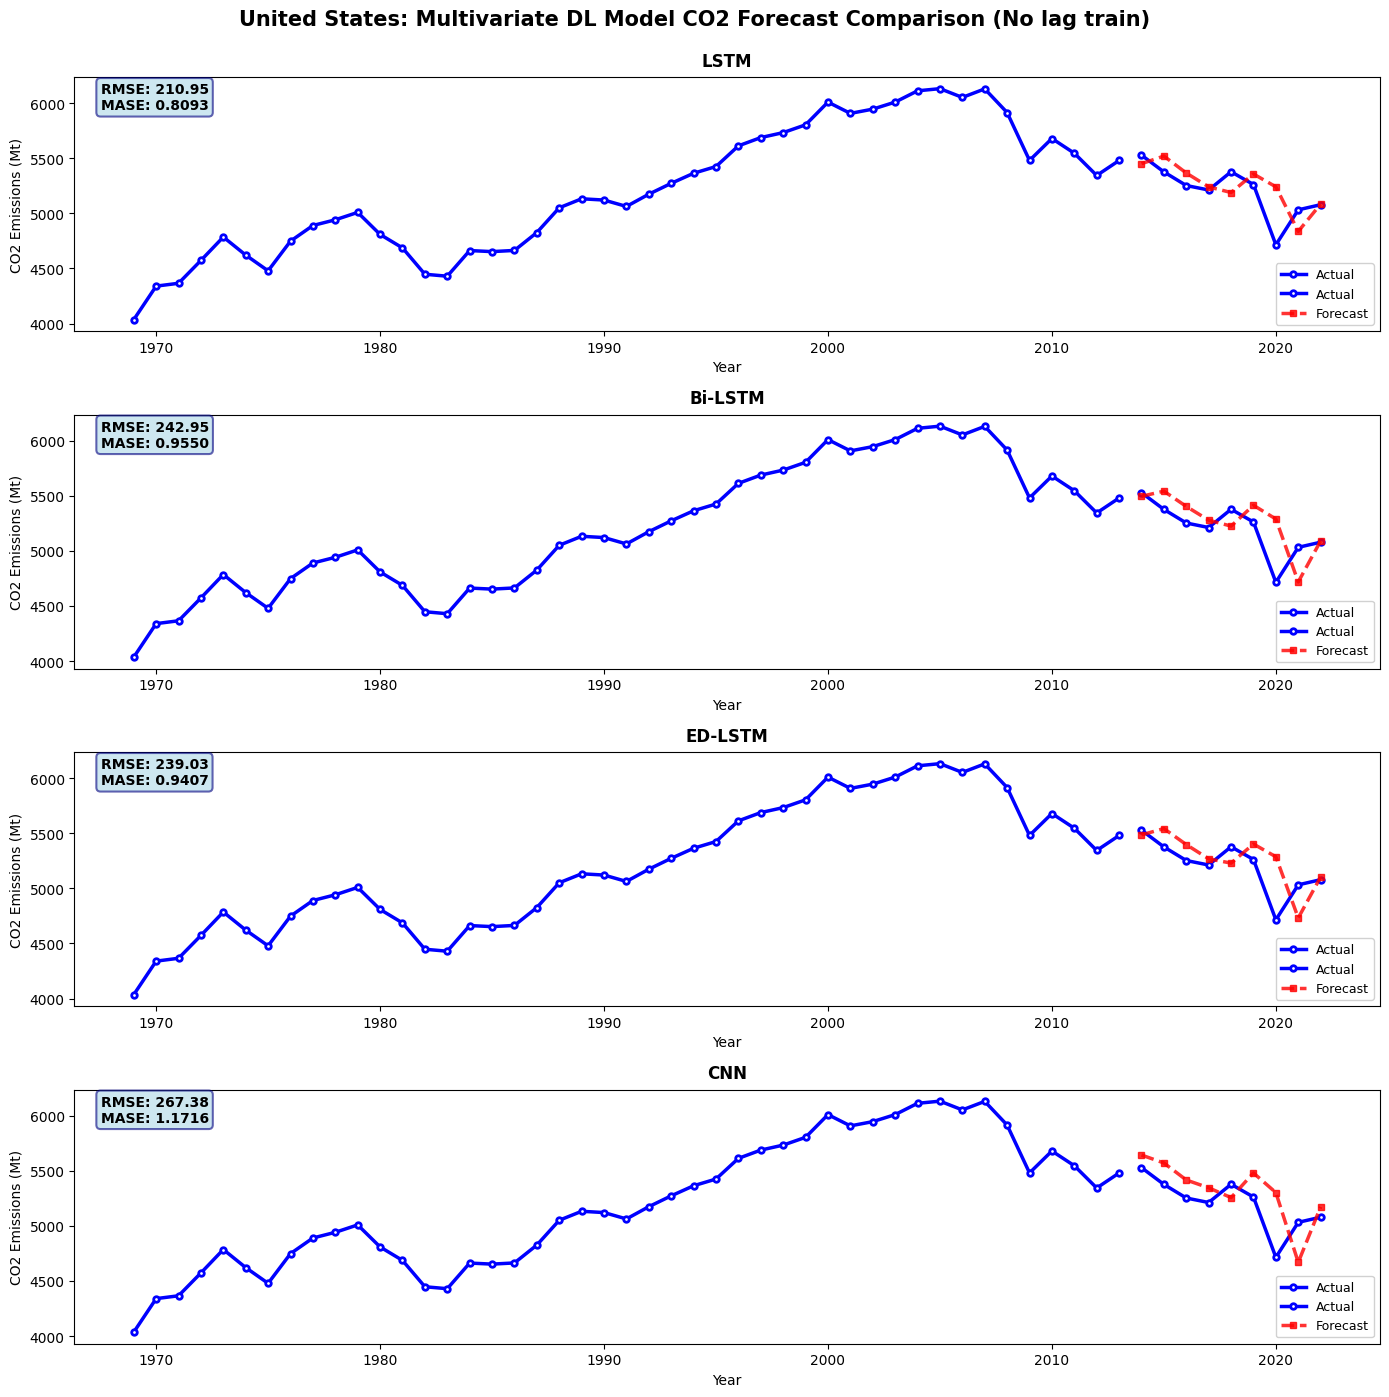

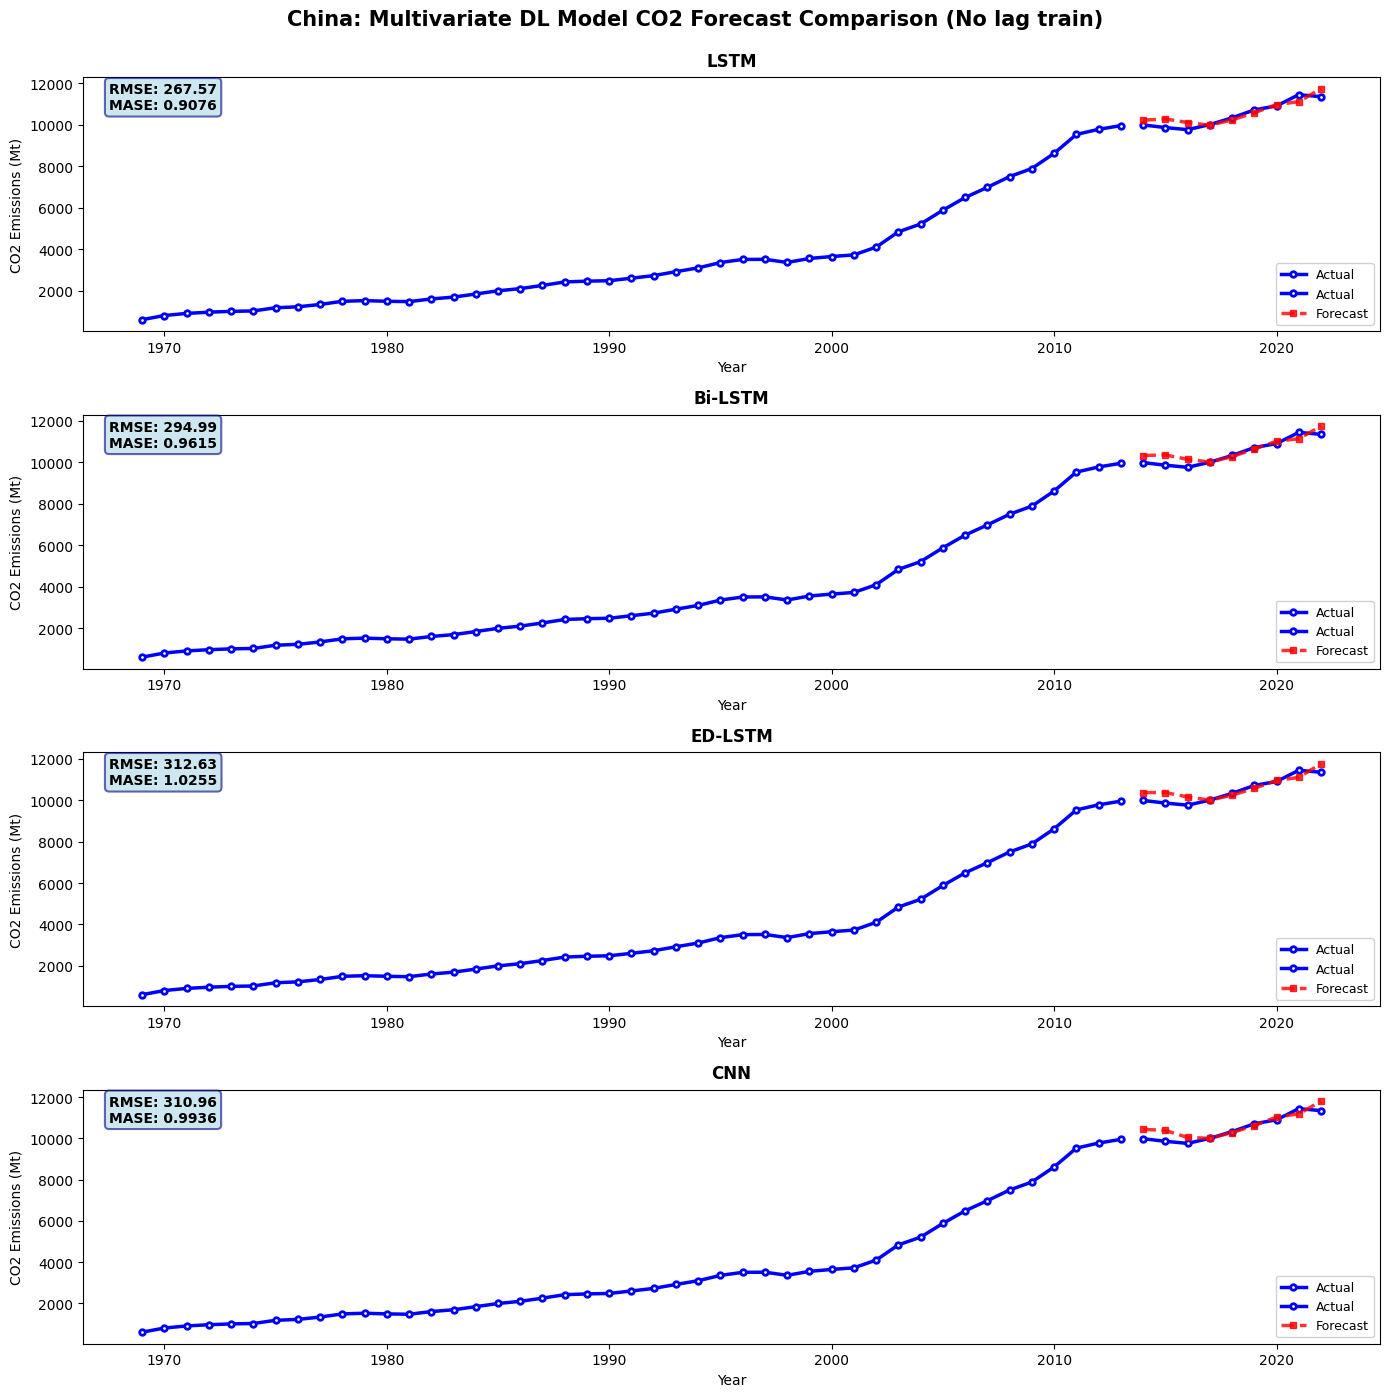

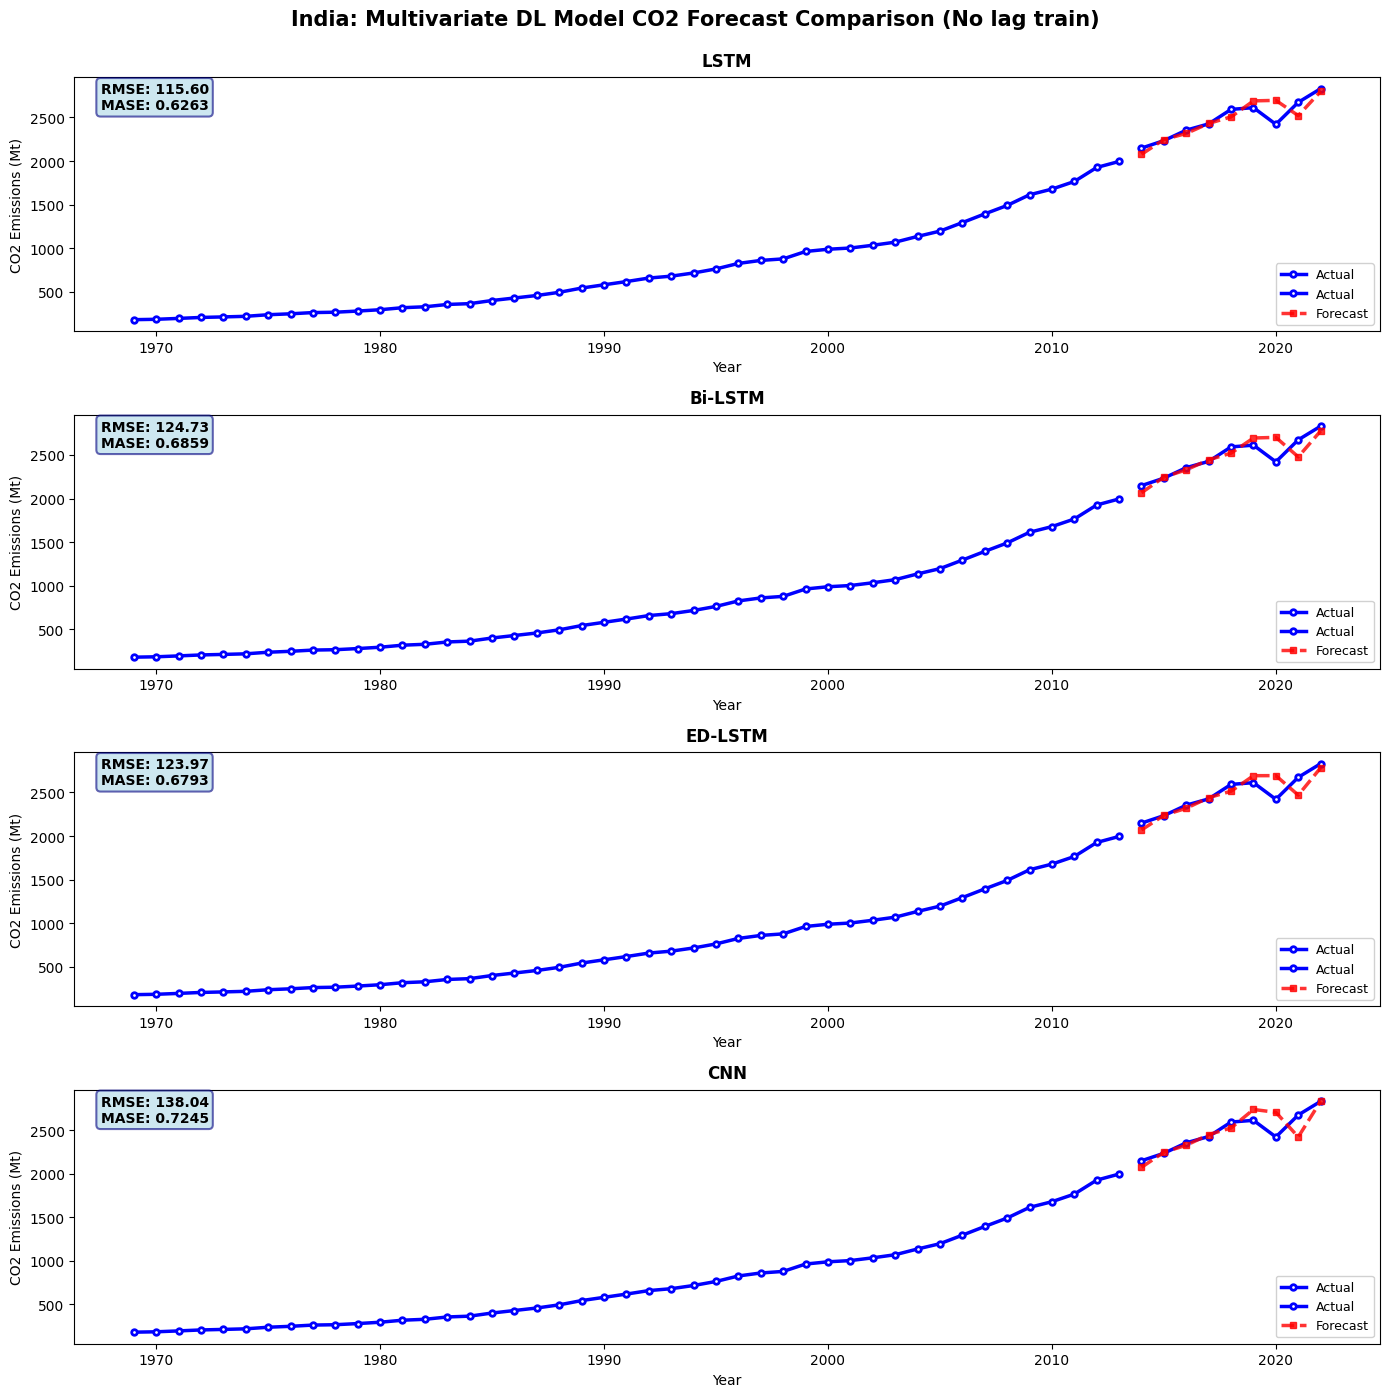

In [41]:
colors = {'actual': 'blue', 'forecast': 'red'}

for country in SELECTED_COUNTRIES:
    print(f"\nCreating plot for {country.upper()}")
     
    train_country = g20_train_df[g20_train_df['country'] == country].sort_values('year')
    test_country = g20_test_df[g20_test_df['country'] == country].sort_values('year')

    fig, axes = plt.subplots(4, 1, figsize=(14, 14))

    for idx, model_name in enumerate(DL_MODELS_ORDER):
        ax = axes[idx]

        # Plot train data
        ax.plot(train_country['year'], train_country[TARGET_VARIABLES], color=colors['actual'], linewidth=2.5,
                label='Actual', marker='o', markersize=4, markerfacecolor='white', markeredgewidth=2,
                markeredgecolor=colors['actual'])
        
        # Plot test actual data
        ax.plot(test_country['year'], test_country[TARGET_VARIABLES], color=colors['actual'], linewidth=2.5,
                label='Actual', marker='o', markersize=4, markerfacecolor='white', markeredgewidth=2,
                markeredgecolor=colors['actual'])
        
        # Plot forecast data
        if model_name in dl_results[country]:
            result = dl_results[country][model_name]
            forecast = result['forecast']
            rmse_score = result['RMSE']
            mase_score = result['MASE']
            test_years = result['test_years']

            ax.plot(test_years, forecast, color=colors['forecast'], linewidth=2.5,
                        linestyle='--', label='Forecast', marker='s', markersize=4, alpha=0.8)

            metrics_str = f"RMSE: {rmse_score:.2f}\nMASE: {mase_score:.4f}"
            props = dict(boxstyle='round', facecolor='lightblue', alpha=0.6, edgecolor='navy', linewidth=1.5)
            ax.text(0.02, 0.98, metrics_str, transform=ax.transAxes, fontsize=10, verticalalignment='top',
                        bbox=props, fontweight='bold')
        else:
             print("    Forecast not found")
            
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold', pad=8)
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel('CO2 Emissions (Mt)', fontsize=10)
        ax.legend(loc='lower right', fontsize=9, framealpha=0.9)

    plt.suptitle(f'{country}: Multivariate DL Model CO2 Forecast Comparison (No lag train)', 
                fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()

    # Save
    plot_filename = f"{country.replace(' ', '_')}_multivariate_g20_model_comparison.png"
    plot_filepath = os.path.join(save_dir, plot_filename)
    plt.savefig(plot_filepath, dpi=150, bbox_inches='tight')

### Comparison of G20 model of three-country target and all-country target

In [42]:
g20_dl_results = eval_on_test(g20_train_df, g20_test_df, TARGET_VARIABLES, ALL_FEATURES, scaler, g20_trained_models, G20_COUNTRIES)


UNITED STATES
Test sequence shape: (9, 5, 8)

  LSTM
    RMSE: 210.9536
    MASE: 0.8093
    Config: {'hidden': 16, 'dropout': 0.1, 'lr': 0.001, 'l2': 0.001, 'batch_size': 32, 'epochs': 100}

  Bi-LSTM
    RMSE: 242.9501
    MASE: 0.9550
    Config: {'hidden': 32, 'dropout': 0.0, 'lr': 0.0001, 'l2': 0.001, 'l2_recurrent': 0.001, 'batch_size': 16, 'epochs': 100}

  ED-LSTM
    RMSE: 239.0302
    MASE: 0.9407
    Config: {'hidden': 8, 'dropout': 0.2, 'lr': 0.001, 'l2': 0.001, 'batch_size': 16, 'epochs': 100}

  CNN
    RMSE: 267.3782
    MASE: 1.1716
    Config: {'filters': 16, 'lr': 0.0001, 'l2': 0.001, 'batch_size': 32, 'epochs': 100}

CHINA
Test sequence shape: (9, 5, 8)

  LSTM
    RMSE: 267.5716
    MASE: 0.9076
    Config: {'hidden': 16, 'dropout': 0.1, 'lr': 0.001, 'l2': 0.001, 'batch_size': 32, 'epochs': 100}

  Bi-LSTM
    RMSE: 294.9877
    MASE: 0.9615
    Config: {'hidden': 32, 'dropout': 0.0, 'lr': 0.0001, 'l2': 0.001, 'l2_recurrent': 0.001, 'batch_size': 16, 'epochs': 100}

In [43]:
three_country_avg = {}

for model_name in DL_MODELS_ORDER:
    rmse_values = []
    mase_values = []
    
    for country in SELECTED_COUNTRIES:
        if model_name in dl_results[country]:
            rmse_values.append(dl_results[country][model_name]['RMSE'])
            mase_values.append(dl_results[country][model_name]['MASE'])
    
    three_country_avg[model_name] = {
        'avg_rmse': np.mean(rmse_values),
        'avg_mase': np.mean(mase_values)
    }

In [44]:
g20_country_avg = {}

for model_name in DL_MODELS_ORDER:
    rmse_values = []
    mase_values = []
    
    for country in G20_COUNTRIES:
        if model_name in g20_dl_results[country]:
            rmse_values.append(g20_dl_results[country][model_name]['RMSE'])
            mase_values.append(g20_dl_results[country][model_name]['MASE'])
    
    g20_country_avg[model_name] = {
        'avg_rmse': np.mean(rmse_values),
        'avg_mase': np.mean(mase_values)
    }

In [45]:
comparison_data = []

for model_name in DL_MODELS_ORDER:
    comparison_data.append({
        'Model': model_name,
        'Avg_RMSE_Three_Countries': three_country_avg[model_name]['avg_rmse'],
        'Avg_MASE_Three_Countries': three_country_avg[model_name]['avg_mase'],
        'Avg_RMSE_G20': g20_country_avg[model_name]['avg_rmse'],
        'Avg_MASE_G20': g20_country_avg[model_name]['avg_mase']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

In [46]:
comparison_filepath = os.path.join(save_dir, 'model_comparison_three_vs_g20.md')

with open(comparison_filepath, 'w') as f:
    f.write("# Model Performance Comparison: Target as Three Countries vs G20 Countries\n\n")
    f.write("- **Training Data**: All G20 countries\n")
    f.write("## Average Performance Metrics\n\n")
    f.write("| Model | Avg RMSE (3 Countries) | Avg MASE (3 Countries) | Avg RMSE (G20) | Avg MASE (G20) |\n")
    f.write("|-------|------------------------|------------------------|----------------|----------------|\n")
    for _, row in comparison_df.iterrows():
        f.write(f"| {row['Model']} | {row['Avg_RMSE_Three_Countries']:.4f} | {row['Avg_MASE_Three_Countries']:.4f} | ")
        f.write(f"{row['Avg_RMSE_G20']:.4f} | {row['Avg_MASE_G20']:.4f} |\n")